# SOPHY Database
### Southern Ocean Phytoplankton Database
- UW Oceanography
- Made by Ayush Nag and Hannah-Joy Warren

# Environment and package setup
Create new environment
- Miniconda is recommended

To explore the data in an interactive web table (Datasette)
- ```conda create -n sophyvenv datasette pandas jupyter tqdm```

To visualize the data using a Jupyter Notebook
- ```conda create -n sophyvenv geopandas cartopy jupyter seaborn tqdm```

If you want to try both
- ```conda create -n sophyvenv datasette geopandas cartopy jupyter seaborn tqdm```

# Import packages

In [6]:
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy
import pandas as pd
from pandas import DataFrame
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
import pyproj
from shapely.ops import transform
from matplotlib.colors import ListedColormap
import matplotlib.path as mpath
from tqdm import tqdm

In [7]:
zones_shapefile = '../data/in/shapefiles/zones/so_zones.shp'
output_xlsx = '../data/out/sophy.xlsx'

# Initialization script
- Builds SOPHY database
- Outputs sophy.db file in virtual environment
- Should be run ONLY once

## Option 1: Explore data in browser with Datasette

In [8]:
print('Building the SOPHY database')
con = sqlite3.connect("sophy.db")
dfs = pd.read_excel(output_xlsx, index_col=0, sheet_name=None)
for table, df in tqdm(dfs.items()):
    df.to_sql(table, if_exists='replace', con=con)
print('SOPHY build successful!')

!datasette sophy.db -o

Building the SOPHY database


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

SOPHY build successful!



INFO:     Started server process [5620]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 10048] error while attempting to bind on address ('127.0.0.1', 8001): only one usage of each socket address (protocol/network address/port) is normally permitted
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


## Option 2: SQLite Database
- Builds in-memory SQLite database
- Opened and closed within this notebook
- Required if you want to use sample queries below
- Outputs result of queries as DataFrame

In [11]:
print('Building the SOPHY database')
con = sqlite3.connect(":memory:")
dfs = pd.read_excel(output_xlsx, index_col=0, sheet_name=None)
for table, df in tqdm(dfs.items()):
    df.to_sql(table, if_exists='replace', con=con)
print('SOPHY build successful!')

# Run this instead if the .db file already exists (have run the previous cell once already)
# con = sqlite3.connect('sophy.db')

Building the SOPHY database


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

SOPHY build successful!


# Query the SOPHY Database.
- General template and sample queries are provided below
- Output is a pandas DataFrame also used for plotting
- Note: Provided sample queries will only work if used with Option 1

In [14]:
# tables = [sample, occurrence, taxonomy, microscopy]
# Query loads all lat, lon from sample and occurrence tables
data: DataFrame = pd.read_sql("select latitude, longitude from sample UNION ALL select latitude, longitude from occurrence;", con=con)
data
# data.to_csv("sample1.csv", index=False)

,latitude,longitude
0,-64.83333,-64.05167
1,-64.83333,-64.05167
2,-64.83333,-64.05167
3,-64.83333,-64.05167
4,-64.83333,-64.05167
...,...,...
68050,-57.00000,170.00000
68051,-57.00000,170.00000
68052,-57.00000,170.00000
68053,-57.00000,170.00000


In [ ]:
# Entries in sample grouped by month and year
data = pd.read_sql("select count(*) as entries, strftime('%Y-%m', timestamp) as year_month from sample group by year_month", con=con)
data

In [8]:
# sectors: ['Ross', 'BA', 'Weddell', 'Indian', 'WPO']
data = pd.read_sql("select * from sample where sample.percent_diatom > 0.8 and sample.sector == 'BA';", con=con)
data

DatabaseError: Execution failed on sql 'select * from sample where sample.percent_diatom > 0.8 and sample.sector == 'BA';': no such table: sample

# Plot setup

In [17]:
def so_map_ax() -> plt.axes:
    map_proj = ccrs.SouthPolarStereo()
    fig = plt.figure(figsize=[12, 12])  # inches
    ax = plt.subplot(projection=map_proj)
    ax.set_extent([-180, 180, -90, -39.4], ccrs.PlateCarree())
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
    ax.add_feature(cartopy.feature.LAND)
    ax.gridlines(xlocs=[-130, -60, 20, 90, 160], draw_labels=True)
    theta  = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
    verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)
    return ax

def make_sectors() -> gpd.GeoDataFrame:
    project = pyproj.Transformer.from_crs(ccrs.PlateCarree(), ccrs.SouthPolarStereo(), always_xy=True).transform
    # Sectors as shapefiles
    s1 = transform(project, Polygon(zip(np.append(np.linspace(start=-130, stop=-60, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s2 = transform(project, Polygon(zip(np.append(np.linspace(start=-60, stop=20, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s3 = transform(project, Polygon(zip(np.append(np.linspace(start=20, stop=90, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s4 = transform(project, Polygon(zip(np.append(np.linspace(start=90, stop=160, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s5 = transform(project, Polygon(zip(np.append(np.append(np.linspace(start=160, stop=180, num=500), np.linspace(start=-180, stop=-130, num=500)), 0), np.append(np.full(1000, -30), -90))))
    s: list = [s1, s2, s3, s4, s5]
    return gpd.GeoDataFrame(geometry=s, crs=ccrs.SouthPolarStereo())

def my_map() -> ListedColormap:
    # Color shades
    greens  = ['#659222', '#7EA640', '#97BB5E', '#AFCF7D', '#C8E49B', '#E1F8B9']
    yellows = ['#B37707', '#CC8E1B', '#E6A52E', '#FFBC42', '#FFCE75', '#FDE3B1']
    maroons = ['#8F2D56', '#A24C70', '#B66A8B', '#C989A5', '#DDA7C0', '#F0C6DA']
    purples = ['#503E8F', '#6E5EA3', '#8B7FB7', '#A99FCA', '#C6C0DE', '#E4E0F2']
    teals   = ['#218380', '#459B99', '#69B2B3', '#8DCACC', '#B1E1E6', '#D5F9FF']
    greens.reverse(), yellows.reverse(), maroons.reverse(), purples.reverse(), teals.reverse()
    # List of all colors
    color_palette = greens + yellows + maroons + purples + teals
    # Make color palette
    return ListedColormap(sns.color_palette(color_palette).as_hex())

# Plot query on Southern Ocean
- Includes zones and sectors
- Modify the data variable (DataFrame) with queries above and plot here

<GeoAxesSubplot: >

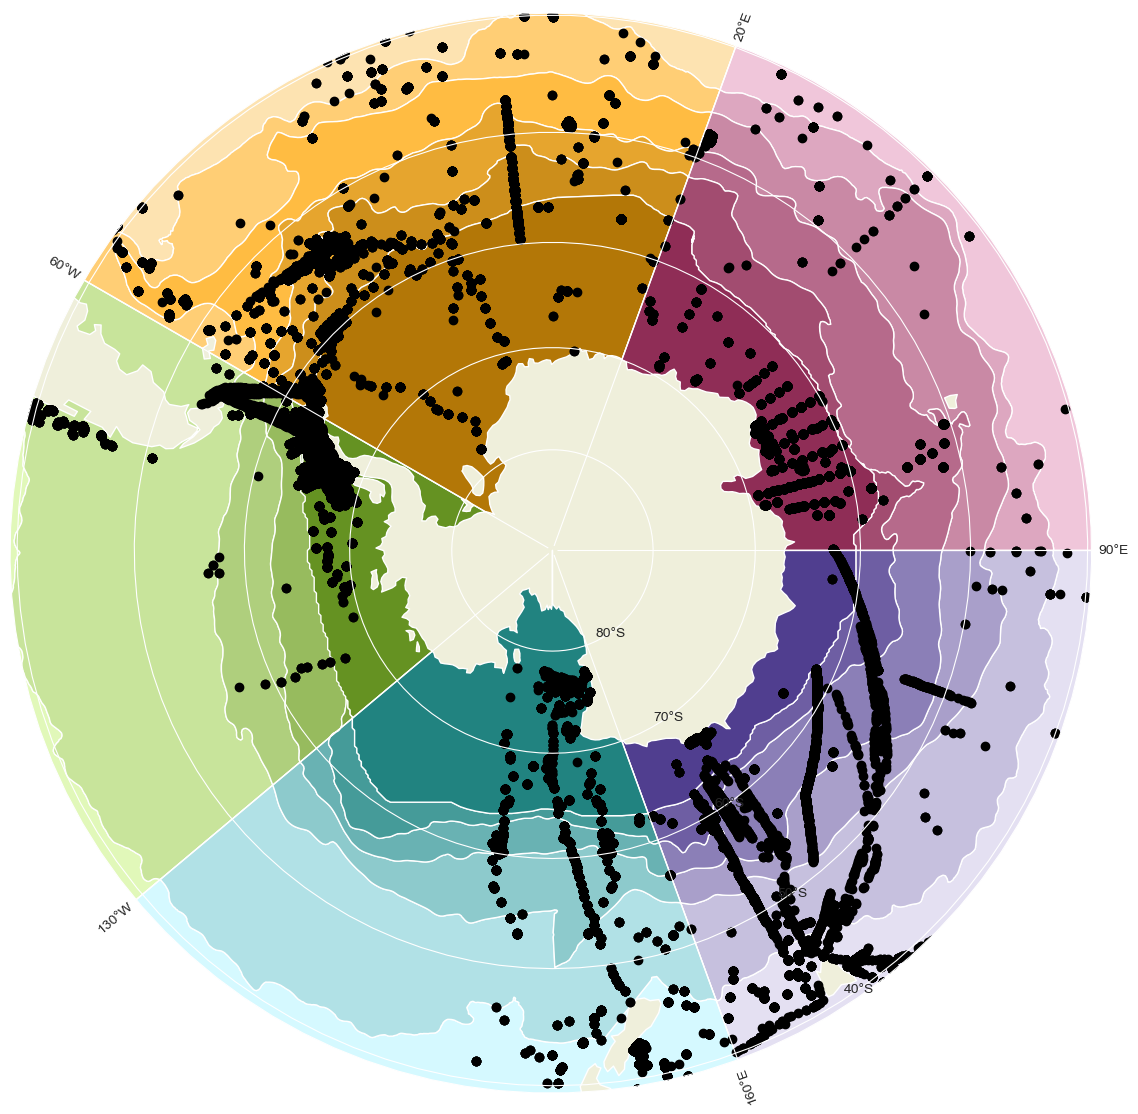

In [20]:
# Generate Southern Ocean plot, GeoDataFrame of sectors, and colormap
ax, sectors, colormap = so_map_ax(), make_sectors(), my_map()
# Get Southern Ocean zones as GeoDataFrame (with shapefiles)
zones: gpd.GeoDataFrame = gpd.read_file(zones_shapefile).to_crs(crs=ccrs.SouthPolarStereo())
# Overlay zones and sectors
res: gpd.GeoDataFrame = zones.overlay(sectors, how='intersection', keep_geom_type=True)
res.plot(ax=ax, cmap=colormap, edgecolor='w', legend=True)
# Plot queried data
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=ccrs.PlateCarree())
data_gdf.to_crs(crs=ccrs.SouthPolarStereo(), inplace=True)
data_gdf.plot(ax=ax, color='k')

In [4]:
# Closes connection and flushes in-memory database
con.close()